In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# For data handling and manipulation
import numpy as np
import pandas as pd
import cv2

# For Visualiztion
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output


# for model building and trining
from keras import backend as K
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, Flatten, Conv2D, MaxPooling2D, Lambda, UpSampling2D, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.initializers import he_normal
from keras.preprocessing.image import ImageDataGenerator

# For organizing data
import os
import shutil


2025-08-18 02:45:42.593770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755485142.608514       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755485142.612903       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 02:45:42.630593: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/usr/local/lib/python3.11/dist-packages/keras/api/preprocessing/image/__init__.py)

In [3]:
# view sample images filenames - bash command
!ls ../input/dog-breed-identification/train/ -U | head -5 


868decd906bb483bac17a005a3f06bc3.jpg
7b44341b91b48e2eafe679c00ba1a0a6.jpg
3a3d8942f7014c126c0c1bf176d0d1a3.jpg
d5a9fac2fa046e3649c845aa9d286e98.jpg
cc4e63a104a2466da58a5f81550c37a4.jpg
ls: write error: Broken pipe


In [4]:
# Firstly, let's use pandas to load the labels and see how they are mapped to data
labels = pd.read_csv('../input/dog-breed-identification/labels.csv')
labels.head(5)


,id,breed
0,8406d837b2d7fac1c3cd621abb4c4f9e,west_highland_white_terrier
1,e270622b5ffec8294d7e7628c4ff6c1e,brittany_spaniel
2,41295c36303043fc587e791b14ef2272,basset
3,b63b0200ddbb97df81972b26574959ab,boxer
4,2c64e362c9aa29450082291264dcba29,flat-coated_retriever


In [5]:
# get number of available classes
classes = np.unique(labels.breed)
classes_num = classes.size
classes_num


120

In [6]:
train_dir = '../input/dog-breed-identification/train'  # the images directory
images_names = os.listdir(train_dir)  # names of the files in the directory
images_num = len(images_names)
print(f'Number of images: {images_num}')  # Number of training images


NameError: name 'os' is not defined

In [7]:
new_train_dir = '/root/new_train/'  # parent directoiry of the training set
new_test_dir = '/root/new_test/'  # parent directory of the validation set
new_valid_dir = '/root/new_valid/'  # parent directory of the test set
!mkdir $new_train_dir
!mkdir $new_test_dir
!mkdir $new_valid_dir


In [8]:
# for each of the parent directories of the sets, we'll create subdirectories for the breeds
for sub_dir in classes:
    os.mkdir(new_train_dir+sub_dir)
    os.mkdir(new_test_dir+sub_dir)
    os.mkdir(new_valid_dir+sub_dir)
!ls $new_train_dir


NameError: name 'os' is not defined

In [9]:
labels_jpg = labels.copy(deep=True)
labels_jpg['id'] += '.jpg'  # add .jpg to each image id to get its filename

# group the images filenames of each breed
grouped_ids = labels_jpg.groupby('breed')['id'].apply(list).to_dict()
print(classes[0], grouped_ids[classes[0]])


affenpinscher ['18b4e732c105272f40956c2f85813bcb.jpg', 'c14d79e9e4e88583fcb603aad4ca2493.jpg', 'f430cdcc2b98a6e3566e71b27ae60e71.jpg', 'b957aa0e8dc0628b09708213e9640a2f.jpg', 'e4a2121c2de5de095855677d4e6eca71.jpg', '6c2a583219893f8c5adc7f604f802a54.jpg', 'a7b2a87a394fd17c848d2bf21cb7fe59.jpg', 'ebf9a3eab9607d1ef1aaaec90de886c9.jpg', 'cf6e0ec97666cf8ddc3de90f1273ff4d.jpg', '38e9c2d8f4f1a26685e80adf8f1b927c.jpg', '6771e15f52bf889dd309f013710995e4.jpg', '040fef64640b89c53f161b6c5215b78b.jpg', '6a2e04aaaa7dc4044b39262db289a12c.jpg', 'b2ecb9fc9cfb36041e60d03f44fc181d.jpg', '1ee0c041d15647e3909625eba419f153.jpg', '83f0bb565b2186dbcc6a9d009cb26ff2.jpg', 'b03a73190ffd9c423257b94927599460.jpg', '5b154e409fe61a86f37e842480f44a10.jpg', '32249ae4f7590aede350e2b08b322ac4.jpg', '5a533f3bae76091d6866fa60ba2ec9d4.jpg', '11b60d8d86f14a601ca290909a17cbc6.jpg', '1a012faf98b32039adc17ee708bcb360.jpg', '5cb8e8855145375221015c02fe21b273.jpg', 'f13e0ce50756b5eb78404b8ee5626c87.jpg', 'ff91c3c095a50d3d7f1ab52b

In [10]:
# specify the required split ratios
test_split = 0.1
valid_split = 0.2


In [11]:
# iterators to track the final sizes of the sets
train_size = 0
valid_size = 0
test_size = 0

# loop on the images of each breed and using the defined probabilities assign each image to one of the 3 sets
for breed_idx, (breed, breed_images) in enumerate(grouped_ids.items()):
    for img in breed_images:
        rnd_prob = np.random.rand()  # give the current image a random number in the range [0, 1]
        if rnd_prob  test_split: 
            # copy to the corresponding breed subdirectory in the test directory
            shutil.copy(train_dir+'/'+img, new_test_dir+'/'+breed) 
            test_size += 1
            
        elif rnd_prob  (test_split + valid_split):
            # copy to the corresponding breed subdirectory in the validation directory
            shutil.copy(train_dir+'/'+img, new_valid_dir+'/'+breed)
            valid_size += 1
            
        else:
            # copy to the corresponding breed subdirectory in the training directory
            shutil.copy(train_dir+'/'+img, new_train_dir+'/'+breed)
            train_size += 1
            
    clear_output(wait=True)
    print(f'Organized {breed_idx+1} out of {classes_num} breeds: {breed}')


SyntaxError: invalid syntax (1928158734.py, line 10)

In [12]:
# let's check the final sizes of the sets
print(train_size, valid_size, test_size)


NameError: name 'train_size' is not defined

In [13]:
# let's check if the organizing process ended as we intended
test_breed = classes[0]
!ls $new_train_dir/$test_breed | head -5


ls: cannot access '/root/new_train//affenpinscher': No such file or directory


In [14]:
# dimensions of images to use for plt.imshow
width, height, channels = 512, 512, 3


In [15]:
# initialize images and labels samples
images_samples = np.zeros((4, height, width, 3), dtype=float)
samples_labels = []

# get random 4 images
rnd_indexes = np.random.randint(0, images_num, 4)
for i, rnd_idx in enumerate(rnd_indexes):
    img_filename = images_names[rnd_idx]
    img_id = img_filename[:-4]
    img_bgr = cv2.imread(train_dir + '/' + img_filename)  # loads the images channels in (blue, green, red) order
    images_samples[i] = cv2.resize(src=img_bgr[:, :, [2, 1, 0]], dsize=(width, height)) / 255  # store the random image
    img_label = labels.breed[labels.id == img_id].values[0]
    samples_labels.append(img_label)  # store the random images' label


NameError: name 'images_num' is not defined

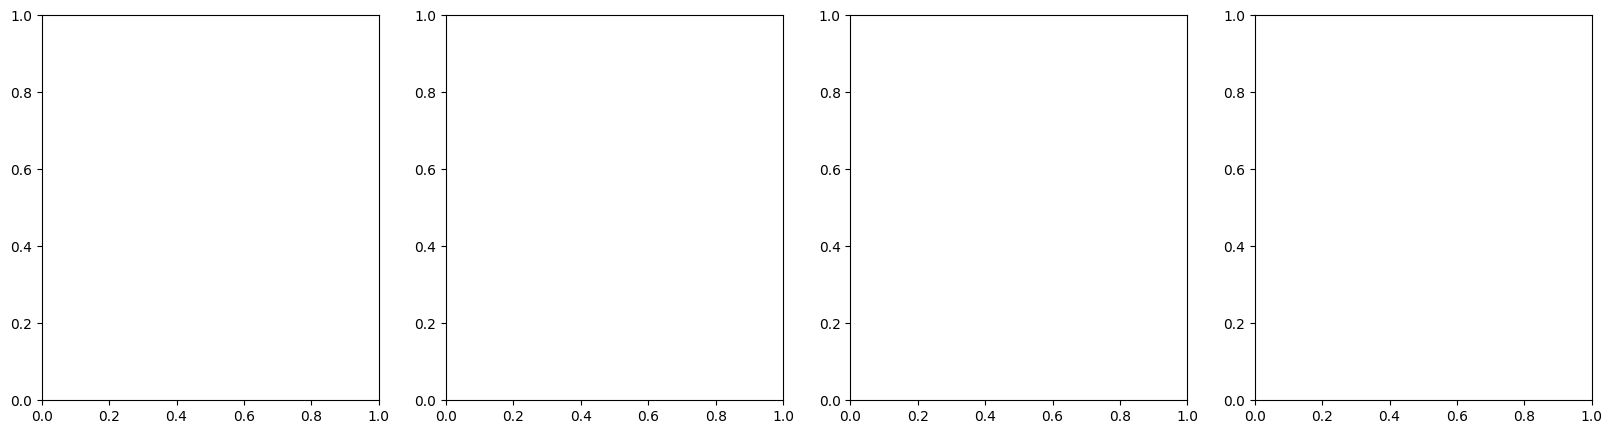

In [16]:
# view the 4 samples
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for ax, img, label in zip(axs.ravel(), images_samples, samples_labels):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Class: {label}', size=15);


In [17]:
norm_factor = 1 / 255

# Augmentation Ranges
transform_params = {
    'featurewise_center': False,
    'featurewise_std_normalization': False,
    'samplewise_center': False,
    'samplewise_std_normalization': False,
    'rotation_range': 30, 
    'width_shift_range': 0.15,
    'height_shift_range': 0.15,
    'horizontal_flip': True,
    'rescale': norm_factor
}

# the generator used for training - gives augmented images
img_gen = ImageDataGenerator(**transform_params) 


NameError: name 'ImageDataGenerator' is not defined

In [18]:
# the generator used for validaiton - gives the images unchanged so that the validation error becomes a good
# indication of the test error
img_feed = ImageDataGenerator(rescale=1/255)


NameError: name 'ImageDataGenerator' is not defined

NameError: name 'img_gen' is not defined

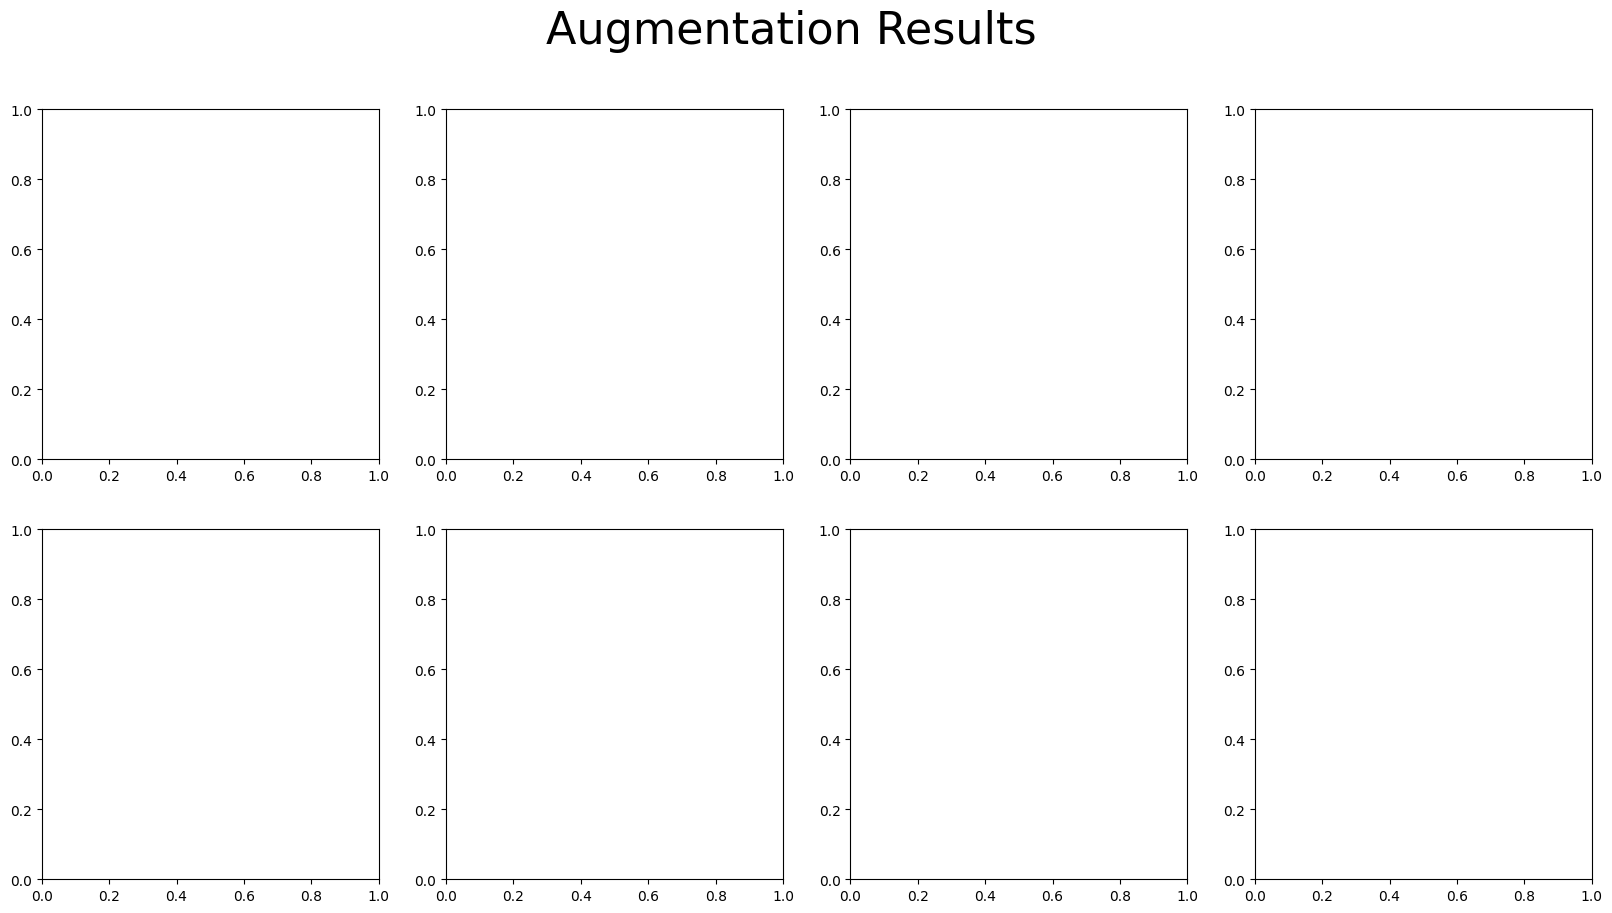

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))  # let's see 4 augmentation examples
fig.suptitle('Augmentation Results', size=32)

for axs_col, img in enumerate(images_samples):
    viz_transoform_params = {  # defined each iteration to get new augmentation values each time
        'theta': np.random.randint(-transform_params['rotation_range'], transform_params['rotation_range']),
        'tx': np.random.uniform(0, transform_params['width_shift_range']),
        'ty': np.random.uniform(0, transform_params['height_shift_range']),
        'flip_horizontal': np.random.choice([True, False], p=[0.5, 0.5])
    }

    aug_img = img_gen.apply_transform(img, viz_transoform_params)  # the same image after augmentation
    
    axs[0, axs_col].imshow(img);
    axs[0, axs_col].axis('off')
    axs[0, axs_col].set_title('Original Image', size=15)
    
    axs[1, axs_col].imshow(aug_img);
    axs[1, axs_col].axis('off')
    axs[1, axs_col].set_title('Augmented Image', size=15)


In [20]:
# used to plot training curves (accuracy, loss) while model is training
class Plotter(Callback):
    def plot(self):  # Updates the graph
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
        # plot the losses
        ax1.plot(self.epochs, self.losses, label='train_loss')
        ax1.plot(self.epochs, self.val_losses, label='val_loss')
        
        # plot the accuracies
        ax2.plot(self.epochs, self.acc, label='train_acc')
        ax2.plot(self.epochs, self.val_acc, label='val_acc')
    
        ax1.set_title(f'Loss vs Epochs')
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss")
        
        ax2.set_title(f'Accuracy vs Epochs')
        ax2.set_xlabel("Epoches")
        ax2.set_ylabel("Accuracy")
        
        ax1.legend()
        ax2.legend()
        plt.show()
        
        # print out the accuracies at each epoch
        print(f'Epoch #{self.epochs[-1]+1} >> train_acc={self.acc[-1]*100:.3f}%, train_loss={self.losses[-1]:.5f}')
        print(f'Epoch #{self.epochs[-1]+1} >> val_acc={self.val_acc[-1]*100:.3f}%, val_loss={self.val_losses[-1]:.5f}')
        
    def on_train_begin(self, logs={}):
        # initialize lists to store values from training
        self.losses = []
        self.val_losses = []
        self.epochs = []
        self.batch_no = []
        self.acc = []
        self.val_acc = []
    
    def on_epoch_end(self, epoch, logs={}):
        # append values from the last epoch
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.epochs.append(epoch)
        self.plot()  # update the graph
        
    def on_train_end(self, logs={}):
        self.plot()
        
    def load_plot_data(self, data):
        self.losses, self.val_losses, self.epochs, self.batch_no, self.acc, self.val_acc = data
    
    def get_plot_data(self):
        return [self.losses, self.val_losses, self.epochs, self.batch_no, self.acc, self.val_acc]
               
plotter = Plotter()


In [21]:
# used to decrease the learning rate if val_acc doesn't enhance
plateau_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.01,
                              patience=1, min_lr=1e-20)


In [22]:
# not used for early stopping, but to rollback to the best weights obtained during training
e_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)


In [23]:
callbacks = [plotter, plateau_reduce, e_stop]


In [24]:
# a Fully connected layer with activation, batchnorm and dropout
def dense_block(x, neurons, layer_no):
    x = Dense(neurons, kernel_initializer=he_normal(layer_no), name=f'topDense{layer_no}')(x)
    x = Activation('relu', name=f'Relu{layer_no}')(x)
    x = BatchNormalization(name=f'BatchNorm{layer_no}')(x)
    x = Dropout(0.5, name=f'Dropout{layer_no}')(x)
    return x


In [25]:
def create_model(shape):
    input_layer = Input(shape, name='input_layer')  # input layer with given shape
    
    # load InceptionResNetV2 with initialized weights and remove final dense layers - frozen layers
    incep_res = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)
    for layer in incep_res.layers:
        layer.trainable = False

    # pooling to reduce dimensionality of each feature map
    pool = MaxPooling2D(pool_size=[3, 3], strides=[3, 3], padding='same')(incep_res.output)
    flat1 = Flatten(name='Flatten1')(pool)
    flat1_bn = BatchNormalization(name='BatchNormFlat')(flat1)
 
    # dense layers after the InceptionResNetV2 initialized layers
    dens1 = dense_block(flat1_bn, neurons=512, layer_no=1)
    dens2 = dense_block(dens1, neurons=512, layer_no=2)
    dens3 = dense_block(dens2, neurons=1024, layer_no=3)
    
    dens_final = Dense(classes_num, name='Dense4')(dens3)
    output_layer = Activation('softmax', name='Softmax')(dens_final)
    
    model = Model(inputs=[input_layer], outputs=[output_layer])

    return model


In [26]:
# hyperparameters
height, width, channels_num = 512, 512, 3
learning_rate = 0.004
epochs = 15
batch_size = 32  # if increased you may run out of gpu memory - reduce image size if to increase the batch size


In [27]:
model = create_model((height, width, channels_num))
optimizer = Adam(learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
model.summary()


2025-08-18 02:45:50.370017: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 255, 255,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 255, 255,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 255, 255,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 253, 253,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 253, 253,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 253, 253,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 253, 253,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 253, 253,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 253, 253,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 126, 126,  │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 126, 126,  │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 126, 126,  │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 124, 124,  │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 124, 124,  │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 124, 124,  │          0 │ batch_normalizat

 Total params: 75,070,808 (286.37 MB)

 Trainable params: 20,653,176 (78.79 MB)

 Non-trainable params: 54,417,632 (207.59 MB)

In [28]:
# used to feed the model augmented training data after being loaded from the directory
train_gen = img_gen.flow_from_directory(directory=new_train_dir, target_size=(height, width), color_mode='rgb', classes=list(classes), 
                                        class_mode='categorical', batch_size=batch_size, shuffle=True, interpolation='nearest')

# used to feed the model augmented validation data after being loaded from the directory
valid_gen = img_feed.flow_from_directory(directory=new_valid_dir, target_size=(height, width), color_mode='rgb', classes=list(classes), 
                                        class_mode='categorical', batch_size=batch_size, shuffle=True, interpolation='nearest')


# # I'll load the decoder layers weights from the same model I trained on colab
# # fit the model using the defined generators
# model.fit_generator(train_gen, validation_data=valid_gen, epochs=epochs, 
#                         steps_per_epoch=train_size//batch_size + 1, 
#                         validation_steps=valid_size//batch_size + 1, callbacks=callbacks)


NameError: name 'img_gen' is not defined

In [29]:
!wget "https://drive.google.com/uc?id=1-3Y-DB5uhOaY69pvVl5rmfirw9aKCYYB&export=download" -O '/root/training_curves.npy'


--2025-08-18 02:45:56--  https://drive.google.com/uc?id=1-3Y-DB5uhOaY69pvVl5rmfirw9aKCYYB&export=download
Resolving drive.google.com (drive.google.com)... 142.251.41.46, 2607:f8b0:400b:803::200e
Connecting to drive.google.com (drive.google.com)|142.251.41.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1-3Y-DB5uhOaY69pvVl5rmfirw9aKCYYB&export=download [following]
--2025-08-18 02:45:56--  https://drive.usercontent.google.com/download?id=1-3Y-DB5uhOaY69pvVl5rmfirw9aKCYYB&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.41.33, 2607:f8b0:400b:803::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.41.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1529 (1.5K) [application/octet-stream]
Saving to: ‘/root/training_curves.npy’

/root/training_curv 100%[===================>]   1.49K  --.-KB/s    i

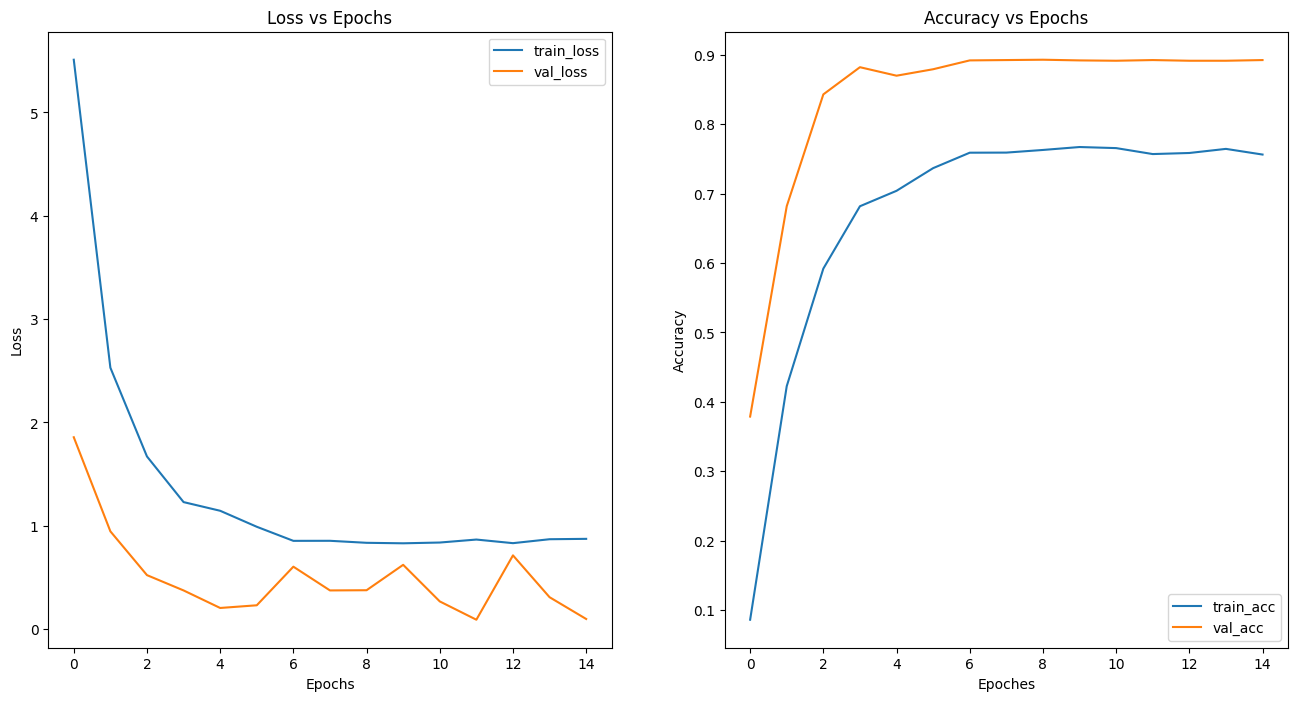

Epoch #15 >> train_acc=75.623%, train_loss=0.87319
Epoch #15 >> val_acc=89.232%, val_loss=0.09762


In [30]:
plot_data = np.load('/root/training_curves.npy', allow_pickle=True)
plotter.load_plot_data(plot_data)  # load the data into the plotter
plotter.plot()


In [31]:
# decoder_weights = {}
# for layer in model.layers[-15:]:
#     decoder_weights[layer.name] = layer.get_weights()


In [32]:
!wget "https://drive.google.com/uc?id=1Omp4wFOWc2WslToduWAgBkyRv9poQVKb&export=download" -O '/root/decoder_weights.npy'


--2025-08-18 02:45:57--  https://drive.google.com/uc?id=1Omp4wFOWc2WslToduWAgBkyRv9poQVKb&export=download
Resolving drive.google.com (drive.google.com)... 142.251.41.46, 2607:f8b0:400b:803::200e
Connecting to drive.google.com (drive.google.com)|142.251.41.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1Omp4wFOWc2WslToduWAgBkyRv9poQVKb&export=download [following]
--2025-08-18 02:45:58--  https://drive.usercontent.google.com/download?id=1Omp4wFOWc2WslToduWAgBkyRv9poQVKb&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.32.65, 2607:f8b0:400b:807::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.32.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82937879 (79M) [application/octet-stream]
Saving to: ‘/root/decoder_weights.npy’

/root/decoder_weigh 100%[===================>]  79.10M  70.7MB/s  

In [33]:
decoder_weights = np.load('/root/decoder_weights.npy', allow_pickle=True).item()
for layer_name, layer_weights in decoder_weights.items():
    model.get_layer(layer_name).set_weights(layer_weights)  # set each layer of the decoder with its weights


In [34]:
# check the dictionary
decoder_weights.keys()


dict_keys(['BatchNormFlat', 'topDense1', 'Relu1', 'BatchNorm1', 'Dropout1', 'topDense2', 'Relu2', 'BatchNorm2', 'Dropout2', 'topDense3', 'Relu3', 'BatchNorm3', 'Dropout3', 'Dense4', 'Softmax'])

In [35]:
# define the test image generator that feeds the labelled test images to the model to evaluate it
test_gen = ImageDataGenerator(rescale=1/255)
test_flow = test_gen.flow_from_directory(new_test_dir,
        target_size=(512, 512),
        batch_size=1,
        shuffle=False)


NameError: name 'ImageDataGenerator' is not defined

In [36]:
# evaluate the model on the labelled test data
metrics = model.evaluate_generator(test_flow, steps=test_size)


AttributeError: 'Functional' object has no attribute 'evaluate_generator'

In [37]:
m_names = model.metrics_names
print(f'{m_names[0]} = {metrics[0]}\n{m_names[1]} = {metrics[1]}')


NameError: name 'metrics' is not defined

In [38]:
# check the corresponding classes of the encoding and ensure it matches the sample submission columns order
one_hot_map = train_gen.class_indices
one_hot_map


NameError: name 'train_gen' is not defined

In [39]:
input_dir = '../input/dog-breed-identification'


In [40]:
test_names = os.listdir(input_dir+'/test')  # names of the files in the directory
test_names.sort()
test_size = len(test_names)
test_size  # number of test images to predict their labels


NameError: name 'os' is not defined

In [41]:
# this flow just returns the test images, one by one, in order
test_flow = test_gen.flow_from_directory(input_dir,
        target_size=(512, 512),
        batch_size=1,
        shuffle=False,
        classes=['test'])  # added test folder as class because keras' flow needs subdirectories hierarchy


NameError: name 'test_gen' is not defined

In [42]:
# # obtain the model's predictions
# y_pred = model.predict_generator(test_flow, steps=test_size)


In [43]:
# # check the shape
# y_pred.shape


In [44]:
# submission = pd.DataFrame(data=y_pred, columns=classes)


In [45]:
# submission.insert(0, "id", test_names, True) 


In [46]:
# submission.id = submission.id.apply(lambda x: x[:-4])


In [47]:
# # check the submission is in the required format
# submission.head(5)


In [48]:
# # save the submission
# submission.to_csv('submission_file.csv', index=False)


In [49]:
# download the submission file obtained from colab
!wget 'https://drive.google.com/uc?id=18IQ9WVf1KcVTgwTgGZXKzx61W0ISayI8&export=download' -O 'submission_colab.csv'


--2025-08-18 02:46:04--  https://drive.google.com/uc?id=18IQ9WVf1KcVTgwTgGZXKzx61W0ISayI8&export=download
Resolving drive.google.com (drive.google.com)... 142.251.41.78, 2607:f8b0:400b:804::200e
Connecting to drive.google.com (drive.google.com)|142.251.41.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=18IQ9WVf1KcVTgwTgGZXKzx61W0ISayI8&export=download [following]
--2025-08-18 02:46:04--  https://drive.usercontent.google.com/download?id=18IQ9WVf1KcVTgwTgGZXKzx61W0ISayI8&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.41.33, 2607:f8b0:400b:803::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.41.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17211367 (16M) [application/octet-stream]
Saving to: ‘submission_colab.csv’

submission_colab.cs 100%[===================>]  16.41M  29.2MB/s    in 